In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")


cpu is available.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка набора данных

Для исследования был выбран набор данных о криптовалюте Эфириум. С записями о почасовых движениях цен ETH / USD.
https://www.kaggle.com/datasets/girish17019/lets-study-ethereum 

История цен доступна на почасовой основе с 17 августа 2017 года, 4 часа утра. Набор содержит историческую информацию о ценах Ethereum по отношению к доллару США.

Open_time : дата и время наблюдения

Open : цена открытия часа

High : Самая высокая цена часа

Low : Самая низкая цена часа

Close : цена закрытия часа

Volume : Объем транзакций за час

In [ ]:
#загружаем датасет
df = pd.read_csv("/content/drive/My Drive/ns/ethusd.csv")
df.head(10)

,Open_time,Open,High,Low,Close,Volume
0,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877
1,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246
2,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672
3,2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510
4,2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029
5,2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879
6,2017-08-17 10:00:00,310.00,310.97,308.54,309.30,284.39140
7,2017-08-17 11:00:00,308.30,310.68,307.78,308.95,273.29040
8,2017-08-17 12:00:00,308.95,310.51,307.98,308.62,401.79278
9,2017-08-17 13:00:00,308.62,309.72,307.77,309.40,310.58042


In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.Close,
        mode="lines",
        name="Close",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.5)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="time", ticklen=5, zeroline=False),
        yaxis=dict(title="Price", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    

In [ ]:
df = df.set_index(['Open_time'])

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic: #на всякий случай отсортируем по индексам (по дате)
    df = df.sort_index()
    
plot_dataset(df, title='Курс ETH / USD')
    

Output hidden; open in https://colab.research.google.com to view.

## Генерация наблюдений с временной задержкой

Добавим дополнительные характеристики - временные шаги

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Close"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 1

df = generate_time_lags(df, input_dim)
df

,Open,High,Low,Close,Volume,lag1
Open_time,,,,,,
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,301.61
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,303.10
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,302.68
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,307.96
2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879,308.62
...,...,...,...,...,...,...
2022-10-03 04:00:00,1291.80,1292.87,1286.79,1288.01,9429.64580,1291.80
2022-10-03 05:00:00,1288.00,1298.80,1284.11,1295.55,20452.59410,1288.01
2022-10-03 06:00:00,1295.55,1301.94,1288.98,1291.70,15813.97580,1295.55


In [ ]:
from sklearn.model_selection import train_test_split

#Разбиение выборки
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df, 'Close', 0.2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(TensorDataset(test_features, test_targets), batch_size=1, shuffle=False, drop_last=True)

In [ ]:
#Архитектура 1
class Net1(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, nonlinearity ='relu', bias=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)#Скрытое состояние

        out, h0 = self.rnn(x, h0.detach())

        # Преобразование конечного состояния в форму для вывода
        out = self.fc(out)
        return out
    
net1 = Net1(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=32, num_layers=1)

In [ ]:
#Архитектура 2
class Net2(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, nonlinearity ='relu', bias=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)#Скрытое состояние

        out, h0 = self.rnn(x, h0.detach())

        # Преобразование конечного состояния в форму для вывода
        out = self.fc(out)
        return out
    
net2 = Net2(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1)

In [ ]:
#Архитектура 3
class Net3(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, nonlinearity ='tanh')
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)#Скрытое состояние

        out, h0 = self.rnn(x, h0.detach())

        # Преобразование конечного состояния в форму для вывода
        out = self.fc(out)
        return out
    
net3 = Net3(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=32, num_layers=1)

In [ ]:
class NetLSTM(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers, dropout_prob):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout_prob)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.lstm(x, (h0.detach(), c0.detach()))

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out
    
netLSTM = NetLSTM(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1, dropout_prob=0.1)

In [ ]:
class NetGRU(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers, dropout_prob):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.gru(x, h0.detach())

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out
    
netGRU = NetGRU(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1, dropout_prob = 0.2)

In [ ]:
from datetime import datetime
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50):
        model_path = f'{self.model.__class__.__name__}'
        best_model_state = None
        best_loss = 9999999.0
        best_epoch = 0

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)

                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_epoch = epoch
                best_model_state = self.model.state_dict()

            if (epoch == 1) | (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Потери обучения: {training_loss:.4f}\t Потери проверки: {validation_loss:.4f}"
                )
                
        self.best_epoch = epoch
        print(f"\tЛучшая эпоха: {best_epoch}")
        print(f"Меньшая ошибка: {best_loss}")
        torch.save(best_model_state, model_path)

    def evaluate(self, test_loader, batch_size=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Потери обучения")
        plt.plot(self.val_losses, label="Потери проверки")
        plt.legend()
        plt.title("Потери")
        plt.show()
        plt.close()

[Net1(
  (rnn): RNN(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), Net2(
  (rnn): RNN(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
), Net3(
  (rnn): RNN(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), NetLSTM(
  (lstm): LSTM(5, 64, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
), NetGRU(
  (gru): GRU(5, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)]
[1/20] Потери обучения: 0.0030	 Потери проверки: 1.1631
[5/20] Потери обучения: 0.0017	 Потери проверки: 0.3078
[10/20] Потери обучения: 0.0003	 Потери проверки: 0.1749
[15/20] Потери обучения: 0.0001	 Потери проверки: 0.1569
[20/20] Потери обучения: 0.0002	 Потери проверки: 0.1314
	Лучшая эпоха: 14
Меньшая ошибка: 0.10496455795612779


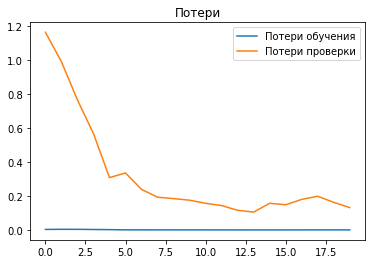

[1/20] Потери обучения: 0.0022	 Потери проверки: 0.3989
[5/20] Потери обучения: 0.0006	 Потери проверки: 0.1974
[10/20] Потери обучения: 0.0003	 Потери проверки: 0.1128
[15/20] Потери обучения: 0.0002	 Потери проверки: 0.1082
[20/20] Потери обучения: 0.0002	 Потери проверки: 0.1005
	Лучшая эпоха: 16
Меньшая ошибка: 0.09597956456291935


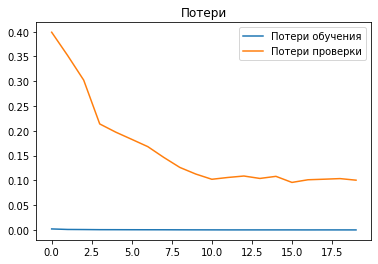

[1/20] Потери обучения: 0.0023	 Потери проверки: 0.8452
[5/20] Потери обучения: 0.0009	 Потери проверки: 0.4739
[10/20] Потери обучения: 0.0002	 Потери проверки: 0.3489
[15/20] Потери обучения: 0.0001	 Потери проверки: 0.3587
[20/20] Потери обучения: 0.0003	 Потери проверки: 0.4583
	Лучшая эпоха: 12
Меньшая ошибка: 0.32084282833697153


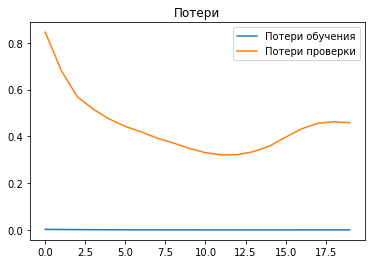

[1/20] Потери обучения: 0.0030	 Потери проверки: 0.6616
[5/20] Потери обучения: 0.0011	 Потери проверки: 0.5607
[10/20] Потери обучения: 0.0003	 Потери проверки: 0.3380
[15/20] Потери обучения: 0.0001	 Потери проверки: 0.2017
[20/20] Потери обучения: 0.0003	 Потери проверки: 0.2897
	Лучшая эпоха: 14
Меньшая ошибка: 0.1953307853272528


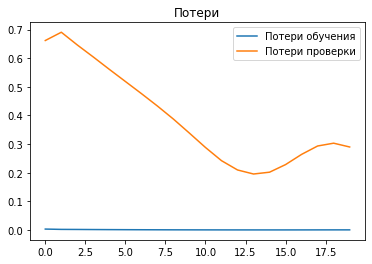

[1/20] Потери обучения: 0.0017	 Потери проверки: 0.5075
[5/20] Потери обучения: 0.0002	 Потери проверки: 0.1060
[10/20] Потери обучения: 0.0001	 Потери проверки: 0.1094
[15/20] Потери обучения: 0.0001	 Потери проверки: 0.0791
[20/20] Потери обучения: 0.0001	 Потери проверки: 0.0799
	Лучшая эпоха: 17
Меньшая ошибка: 0.07021174653646897


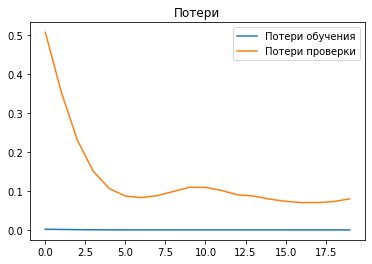

In [ ]:
import torch.optim as optim
models = [net1, net2, net3, netLSTM, netGRU]
num_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

optimizers = list()
loss_fn = nn.MSELoss()

print(models)
for model in models:
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    optimizers.append(opt)

for opt in optimizers:
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=num_epochs)
    opt.plot_losses()

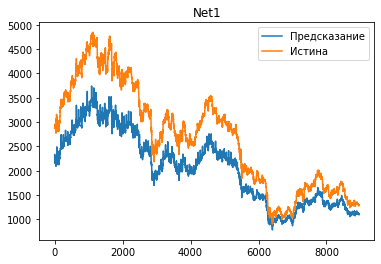

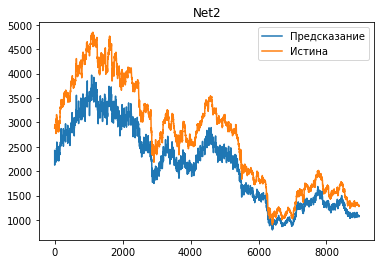

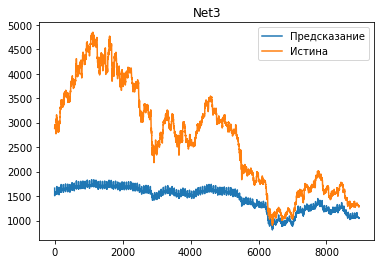

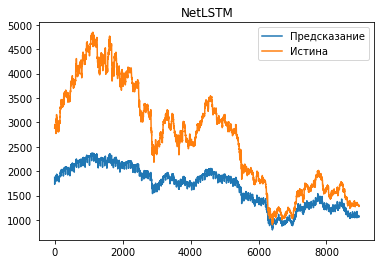

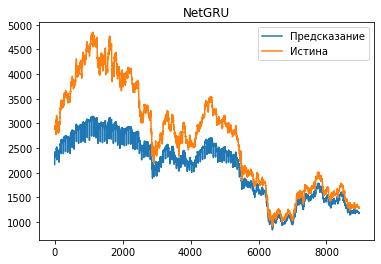

In [ ]:
predictions_storage = []

for opt in optimizers:
    predictions, values = opt.evaluate(test_loader, batch_size)
    vals = np.array([])
    preds = np.array([])
    for pred, value in zip(predictions, values):
        vals = np.append(vals, value)
        preds = np.append(preds, pred)
        
    vals = scaler.inverse_transform(vals.reshape(-1, 1))
    preds = scaler.inverse_transform(preds.reshape(-1, 1))

    plt.plot(preds, label="Предсказание")
    plt.plot(vals, label="Истина")
    plt.legend()
    plt.title(f"{opt.model.__class__.__name__}")
    plt.show()
    plt.close()
    predictions_storage.append([opt.model.__class__.__name__, preds, vals])